<a href="https://www.kaggle.com/jarupula/google-ventilator-pressure-prediction-lstm?scriptVersionId=88616714" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Google - VPP 

In [1]:
import gc
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Concatenate, LSTM, GRU
from tensorflow.keras.layers import Bidirectional, Multiply

from scipy.signal import hilbert, chirp
from scipy.signal import blackman
from scipy.fft import fft, fftfreq

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

2022-02-24 05:48:19.100050: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-24 05:48:19.100185: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train = pd.read_csv('../input/ventilator-pressure-prediction/train.csv')
test = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')
sample_sub = pd.read_csv('../input/ventilator-pressure-prediction/sample_submission.csv')

In [3]:
all_pressure = sorted(train.pressure.unique())

PRESSURE_MIN = np.min(all_pressure)
PRESSURE_MAX = np.max(all_pressure)
PRESSURE_STEP = all_pressure[1] - all_pressure[0]

# FE

In [4]:
N = 80
w = blackman(N+1)

ffta = lambda x: np.abs(fft(np.append(x.values,x.values[0]))[:80])
ffta.__name__ = 'ffta'

fftw = lambda x: np.abs(fft(np.append(x.values,x.values[0])*w)[:80])
fftw.__name__ = 'fftw'

def add_features(df):
    print('Basic FE')
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df = df.fillna(0)
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_out__max'] = df.groupby(['breath_id'])['u_out'].transform('max')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']

    print('EWM FE')
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df['ewm_u_in_std'] = df.groupby('breath_id')['u_in'].ewm(halflife=10).std().reset_index(level=0,drop=True)
    df['ewm_u_in_corr'] = df.groupby('breath_id')['u_in'].ewm(halflife=10).corr().reset_index(level=0,drop=True)
    
    df['u_in_1st_derivative'] = (df['u_in'].diff().fillna(0) / df['time_step'].diff().fillna(0)).fillna(0)
    df['expand_mean_1sr_der'] = df.groupby('breath_id')['u_in_1st_derivative'].expanding(2).mean().reset_index(level=0,drop=True)
    df['u_in_1st_der_mean10'] = df.groupby('breath_id')['u_in_1st_derivative'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
    
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"
                                                                    #"15_in_std":"std"
                                                               })\
                                                               .reset_index(level=0,drop=True))
    print('Rolling')
    df['rolling_10_mean'] = df.groupby('breath_id')['u_in'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
    df['rolling_10_max'] = df.groupby('breath_id')['u_in'].rolling(window=10, min_periods=1).max().reset_index(level=0,drop=True)
    df['rolling_10_std'] = df.groupby('breath_id')['u_in'].rolling(window=10, min_periods=1).std().reset_index(level=0,drop=True)
             
    df['expand_mean'] = df.groupby('breath_id')['u_in'].expanding(2).mean().reset_index(level=0,drop=True)
    df['expand_max'] = df.groupby('breath_id')['u_in'].expanding(2).max().reset_index(level=0,drop=True)
    df['expand_std'] = df.groupby('breath_id')['u_in'].expanding(2).std().reset_index(level=0,drop=True)
    
    df['delta_u_in'] = abs(df.groupby(df['breath_id'])['u_in'].diff().fillna(0)).reset_index(level=0,drop=True)
    df['delta_u_in_exp'] = df.groupby(df['breath_id'])['delta_u_in'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
    df['delta_rolling_10_mean'] = df.groupby('breath_id')['delta_u_in'].rolling(window=10, min_periods=1).mean().reset_index(level=0,drop=True)
    df['delta_rolling_10_max'] = df.groupby('breath_id')['delta_u_in'].rolling(window=10, min_periods=1).max().reset_index(level=0,drop=True)
    
    print('Work')
    df['work']=((df['u_in'] + df['u_in'].shift(1).fillna(0))/2 * df['time_step'].diff().fillna(0)).clip(0,)
    df['work_roll_10']=df.groupby(df['breath_id'])['work'].rolling(window=10, min_periods=1).sum().reset_index(level=0,drop=True)
    df['work_roll_15']=df.groupby(df['breath_id'])['work'].rolling(window=15, min_periods=1).sum().reset_index(level=0,drop=True)
      
    df['u_in_rol_q0.1'] = df.groupby(df['breath_id'])['u_in'].rolling(window=10, min_periods=1).quantile(0.1).reset_index(level=0,drop=True)
    df['u_in_rol_q0.25'] = df.groupby(df['breath_id'])['u_in'].rolling(window=10, min_periods=1).quantile(0.25).reset_index(level=0,drop=True)
    df['u_in_rol_q0.5'] = df.groupby(df['breath_id'])['u_in'].rolling(window=10, min_periods=1).quantile(0.5).reset_index(level=0,drop=True)
    df['u_in_rol_q0.75'] = df.groupby(df['breath_id'])['u_in'].rolling(window=10, min_periods=1).quantile(0.75).reset_index(level=0,drop=True)
    df['u_in_rol_q0.9'] = df.groupby(df['breath_id'])['u_in'].rolling(window=10, min_periods=1).quantile(0.9).reset_index(level=0,drop=True)
    
    print('Fourier')
    df['fft_u_in'] = df.groupby('breath_id')['u_in'].transform(ffta)
    df['fft_u_in_w'] = df.groupby('breath_id')['u_in'].transform(fftw)
    df['analytical'] = df.groupby('breath_id')['u_in'].transform(hilbert)
    df['envelope'] = np.abs(df['analytical'])
    df['phase'] = np.angle(df['analytical'])
    df['unwrapped_phase'] = df.groupby('breath_id')['phase'].transform(np.unwrap)
    df['phase_shift1'] = df.groupby('breath_id')['unwrapped_phase'].shift(1).astype(np.float32)
    df['IF'] = df['unwrapped_phase'] - df['phase_shift1'].astype(np.float32)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    df = df.fillna(0)
    df = df.drop('analytical',axis=1)
    print('Done processing...\n')
    return df

In [5]:
print('Processing training set...\n')
train = add_features(train)
print('Processing test set...\n')
test = add_features(test)

Processing training set...

Basic FE
EWM FE
Rolling
Work
Fourier
Done processing...

Processing test set...

Basic FE
EWM FE
Rolling
Work
Fourier
Done processing...



In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2872.43 MB
Memory usage after optimization is: 874.97 MB
Decreased by 69.5%
Memory usage of dataframe is 1884.25 MB
Memory usage after optimization is: 575.64 MB
Decreased by 69.5%


# Training

In [8]:
@tf.custom_gradient
def round_with_gradients(x):
    def grad(dy):
        return dy
    return tf.round(x), grad

class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ScaleLayer, self).__init__()
        self.min = tf.constant(PRESSURE_MIN, dtype=np.float32)
        self.max = tf.constant(PRESSURE_MAX, dtype=np.float32)
        self.step = tf.constant(PRESSURE_STEP, dtype=np.float32)

    def call(self, inputs):
        steps = tf.math.divide(tf.math.add(inputs, -self.min), self.step)
        int_steps = round_with_gradients(steps)
        rescaled_steps = tf.math.add(tf.math.multiply(int_steps, self.step), self.min)
        clipped = tf.clip_by_value(rescaled_steps, self.min, self.max)
        return clipped

In [9]:
targets = train[['pressure']].to_numpy().reshape(-1, 80)

train.drop(['pressure','id', 'breath_id','one','count'], axis=1, inplace=True)

test = test.drop(['id', 'breath_id','one','count'], axis=1)

In [10]:
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [11]:
train = train.reshape(-1, 80, train.shape[-1])
test = test.reshape(-1, 80, train.shape[-1])

In [12]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

2022-02-24 05:57:18.796271: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-24 05:57:18.799476: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-02-24 05:57:18.799524: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-24 05:57:18.799551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (407758aef94f): /proc/driver/nvidia/version does not exist
2022-02-24 05:57:18.803041: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU: grpc://10.0.0.2:8470
Batch Size: 512


In [13]:
def dnn_model():
    
    x_input = Input(shape=(train.shape[-2:]))
    
    x1 = Bidirectional(LSTM(units=768, return_sequences=True))(x_input)
    x2 = Bidirectional(LSTM(units=512, return_sequences=True))(x1)
    x3 = Bidirectional(LSTM(units=384, return_sequences=True))(x2)
    x4 = Bidirectional(LSTM(units=256, return_sequences=True))(x3)
    x5 = Bidirectional(LSTM(units=128, return_sequences=True))(x4)
    
    z2 = Bidirectional(GRU(units=384, return_sequences=True))(x2)
    
    z31 = Multiply()([x3, z2])
    z31 = BatchNormalization()(z31)
    z3 = Bidirectional(GRU(units=256, return_sequences=True))(z31)
    
    z41 = Multiply()([x4, z3])
    z41 = BatchNormalization()(z41)
    z4 = Bidirectional(GRU(units=128, return_sequences=True))(z41)
    
    z51 = Multiply()([x5, z4])
    z51 = BatchNormalization()(z51)
    z5 = Bidirectional(GRU(units=64, return_sequences=True))(z51)
    
    x = Concatenate(axis=2)([x5, z2, z3, z4, z5])
    
    x = Dense(units=128, activation='selu')(x)
    
    x_output = Dense(units=1)(x)

    model = Model(inputs=x_input, outputs= x_output, 
                  name='DNN_Model')
    return model

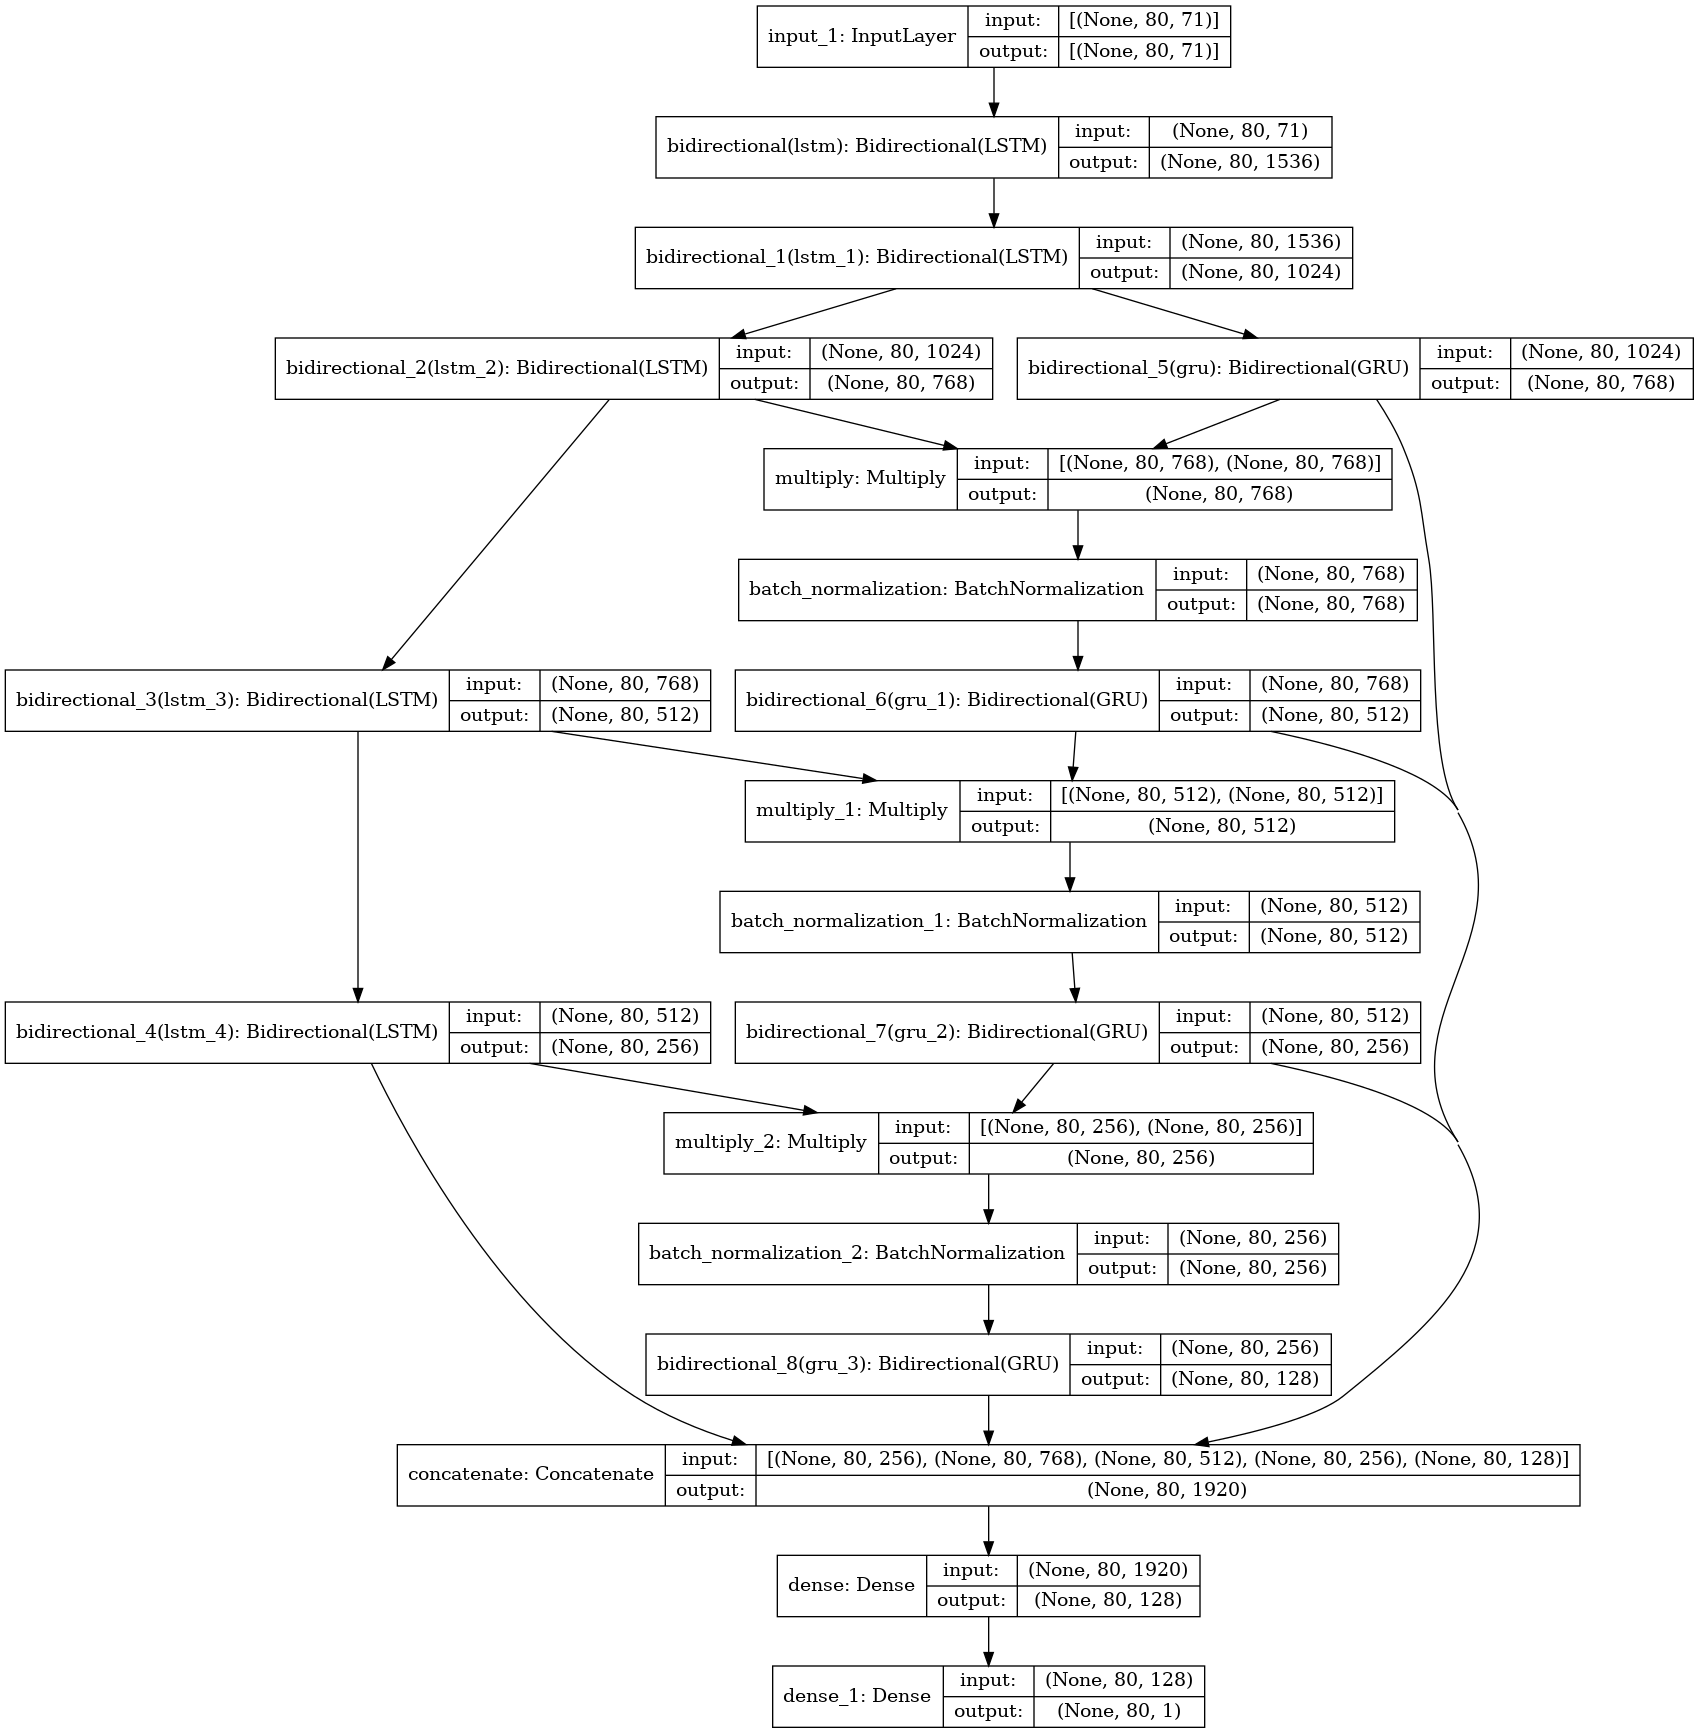

In [14]:
model = dnn_model()

plot_model(
    model, 
    to_file='Google_Brain_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [15]:
with strategy.scope():
    
    VERBOSE = 0
    test_preds = []
    
    kf = KFold(n_splits=7, shuffle=True, random_state=42)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        
        model = dnn_model()
        model.compile(optimizer="adam", loss="mae")

        lr = ReduceLROnPlateau(monitor="val_loss", factor=0.75, 
                               patience=10, verbose=VERBOSE)
        
        save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
        chk_point = ModelCheckpoint(f'./Bidirect_LSTM_model_{fold+1}C.h5', options=save_locally, 
                                    monitor='val_loss', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')

        es = EarlyStopping(monitor="val_loss", patience=50, 
                           verbose=VERBOSE, mode="min", 
                           restore_best_weights=True)
        
        model.fit(X_train, y_train, 
                  validation_data=(X_valid, y_valid), 
                  epochs=300,
                  verbose=VERBOSE,
                  batch_size=BATCH_SIZE, 
                  callbacks=[lr, chk_point, es])
        
        load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
        model = load_model(f'./Bidirect_LSTM_model_{fold+1}C.h5', options=load_locally)
        
        y_true = y_valid.squeeze().reshape(-1, 1)
        y_pred = model.predict(X_valid, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1)
        score = mean_absolute_error(y_true, y_pred)
        print(f"Fold-{fold+1} | OOF Score: {score}")
        
        test_preds.append(model.predict(test, batch_size=BATCH_SIZE).squeeze().reshape(-1, 1).squeeze())

2022-02-24 05:58:00.670546: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1469325120 exceeds 10% of free system memory.


Fold-1 | OOF Score: 0.16687484085559845


2022-02-24 06:56:38.405501: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1142816000 exceeds 10% of free system memory.
2022-02-24 06:57:05.436434: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1469325120 exceeds 10% of free system memory.


Fold-2 | OOF Score: 0.16478778421878815


2022-02-24 07:58:31.978739: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1142816000 exceeds 10% of free system memory.
2022-02-24 07:59:02.443696: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1469325120 exceeds 10% of free system memory.


Fold-3 | OOF Score: 0.16580550372600555
Fold-4 | OOF Score: 0.16516783833503723
Fold-5 | OOF Score: 0.16428254544734955
Fold-6 | OOF Score: 0.1642252504825592
Fold-7 | OOF Score: 0.16228587925434113


# Submitting

In [16]:
sample_sub["pressure"] = np.median(np.vstack(test_preds), axis=0)
sample_sub.to_csv('submission.csv', index=False)
sample_sub.head()

,id,pressure
0,1,6.282407
1,2,5.976163
2,3,7.111057
3,4,7.629276
4,5,9.127869
